# Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Análisis exploratorio

In [2]:
rankings = pd.read_csv('Data/ds_index_next.csv')
final = rankings.copy()
rankings.shape

(87438, 43)

In [3]:
rankings.head()

,YEAR,CODE,VQ_MARKET_CAP,CSR__ROE,VR__EV_TO_EBIT,CSR__ROC_JOEL_GREENBLATT,CSR__OPERATING_MARGIN,VQ__PIOTROSKI_F_SCORE,VR__PS_RATIO,VR__PB_RATIO,...,RISK,INDUSTRY01,INDUSTRY02,RETURNS_NEXT,RETURNS_CAT,RETURNS_NEXT_CAT,INDEX_RETURNS,INDEX_RETURNS_NEXT,RETURNS_vs_INDEX,RETURNS_vs_INDEX_NEXT
0,2014,ETE,31002.7009,72.22,28.98,8.00,5.10,7,0.56,46.73,...,3.472920,NaN,NaN,-0.512675,POSITIVE,NEGATIVE,0.123866,-0.006928,WINS,LOSES
1,2010,ETE,8712.4952,317.83,24.53,9.21,15.92,5,1.33,72.37,...,0.730981,NaN,NaN,0.045082,POSITIVE,POSITIVE,0.110019,-0.011220,WINS,WINS
2,2015,ETE,14384.6808,0.00,28.67,5.90,7.28,7,0.41,0.00,...,6.159618,NaN,NaN,0.897959,NEGATIVE,POSITIVE,-0.006928,0.112374,LOSES,WINS
3,2012,ETE,12732.3534,27.89,19.82,11.46,8.02,5,0.73,6.03,...,0.649843,NaN,NaN,0.657980,POSITIVE,POSITIVE,0.116776,0.263905,WINS,WINS
4,2007,ETE,8191.2308,2122.84,25.13,14.74,11.92,5,1.16,0.00,...,0.797453,NaN,NaN,-0.502987,POSITIVE,NEGATIVE,0.036538,-0.375847,WINS,LOSES


## Preprocesamiento de variables

In [4]:
rankings.query('YEAR > 2005 & YEAR < 2016', inplace=True)

In [5]:
rankings.drop(['INDUSTRY01', 'INDUSTRY02', 'RETURNS_NEXT', 'RETURNS_NEXT_CAT',
                 'INDEX_RETURNS_NEXT'], axis=1, inplace=True)

In [6]:
for c in rankings.columns:
    if c not in ['YEAR', 'CODE', 'VQ__PIOTROSKI_F_SCORE', 'RETURNS_CAT',
                 'RETURNS_vs_INDEX', 'RETURNS_vs_INDEX_NEXT']:
        for y in rankings['YEAR'].unique():
            tmp = rankings.query('YEAR == @y')[c]
            q1 = tmp.quantile(0.25)
            q3 = tmp.quantile(0.75)
            iqr = q3-q1 #Interquartile range
            fence_low  = q1-1.5*iqr
            fence_high = q3+1.5*iqr
            
            rankings[c][(rankings['YEAR'] == y) & (rankings[c] < fence_low)] = fence_low
            rankings[c][(rankings['YEAR'] == y) & (rankings[c] > fence_high)] = fence_high

In [7]:
le = LabelEncoder()
rankings['RETURNS_CAT'] = le.fit_transform(rankings['RETURNS_CAT'])
rankings['RETURNS_vs_INDEX'] = le.fit_transform(rankings['RETURNS_vs_INDEX'])
rankings['RETURNS_vs_INDEX_NEXT'] = le.fit_transform(rankings['RETURNS_vs_INDEX_NEXT'])

In [8]:
rankings.drop(['YEAR', 'CODE'], axis=1, inplace=True)

# División y escalado de datos

In [9]:
X = rankings.drop(['RETURNS_vs_INDEX_NEXT'], axis = 1)
y = rankings['RETURNS_vs_INDEX_NEXT']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, random_state=10, test_size=0.20)

In [11]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

# Algoritmo

In [12]:
n_folds = 5
early_stopping = 10

params = {
    'eta': 0.015,
    'max_depth': 10,
    'min_child_weight': 6,
    'subsample': 0.7,
    'colsample_bytre': 1,
    'objective': 'binary:logistic',
    'seed': 99,
    'silent': 1,
    'eval_metric': 'error',
    'nthread': 4}

In [13]:
cv = xgb.cv(params, xg_train, 300, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-error:0.349472+0.00260417	test-error:0.385592+0.00426044
[1]	train-error:0.332713+0.00148722	test-error:0.372818+0.00216136
[2]	train-error:0.327496+0.0022492	test-error:0.366644+0.00499893
[3]	train-error:0.324908+0.00246489	test-error:0.362199+0.00379557
[4]	train-error:0.322666+0.00180355	test-error:0.360789+0.00484839
[5]	train-error:0.32087+0.00197526	test-error:0.359032+0.00660294
[6]	train-error:0.319592+0.00156266	test-error:0.359325+0.0061237
[7]	train-error:0.318169+0.00183442	test-error:0.357329+0.00539539
[8]	train-error:0.318115+0.00197679	test-error:0.358793+0.00430087
[9]	train-error:0.318049+0.00190798	test-error:0.356877+0.00412363
[10]	train-error:0.316938+0.00133813	test-error:0.357568+0.00390896
[11]	train-error:0.316272+0.00191007	test-error:0.356531+0.00263635
[12]	train-error:0.316132+0.00257492	test-error:0.35685+0.00268259
[13]	train-error:0.315274+0.00301393	test-error:0.356025+0.00326236
[14]	train-error:0.315075+0.0028683	test-error:0.354801+0.0030

In [14]:
model = xgb.train(params=params, dtrain=xg_train, num_boost_round=cv.shape[0])

In [15]:
print("Accuracy Train: %.2f%%" % (accuracy_score(y_train,
                                                 [round(value) for value in model.predict(xg_train)]) * 100.0))

Accuracy Train: 68.77%


In [16]:
print("Accuracy Test: %.2f%%" % (accuracy_score(y_test,
                                                [round(value) for value in model.predict(xg_test)]) * 100.0))

Accuracy Test: 65.56%


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.903568 to fit


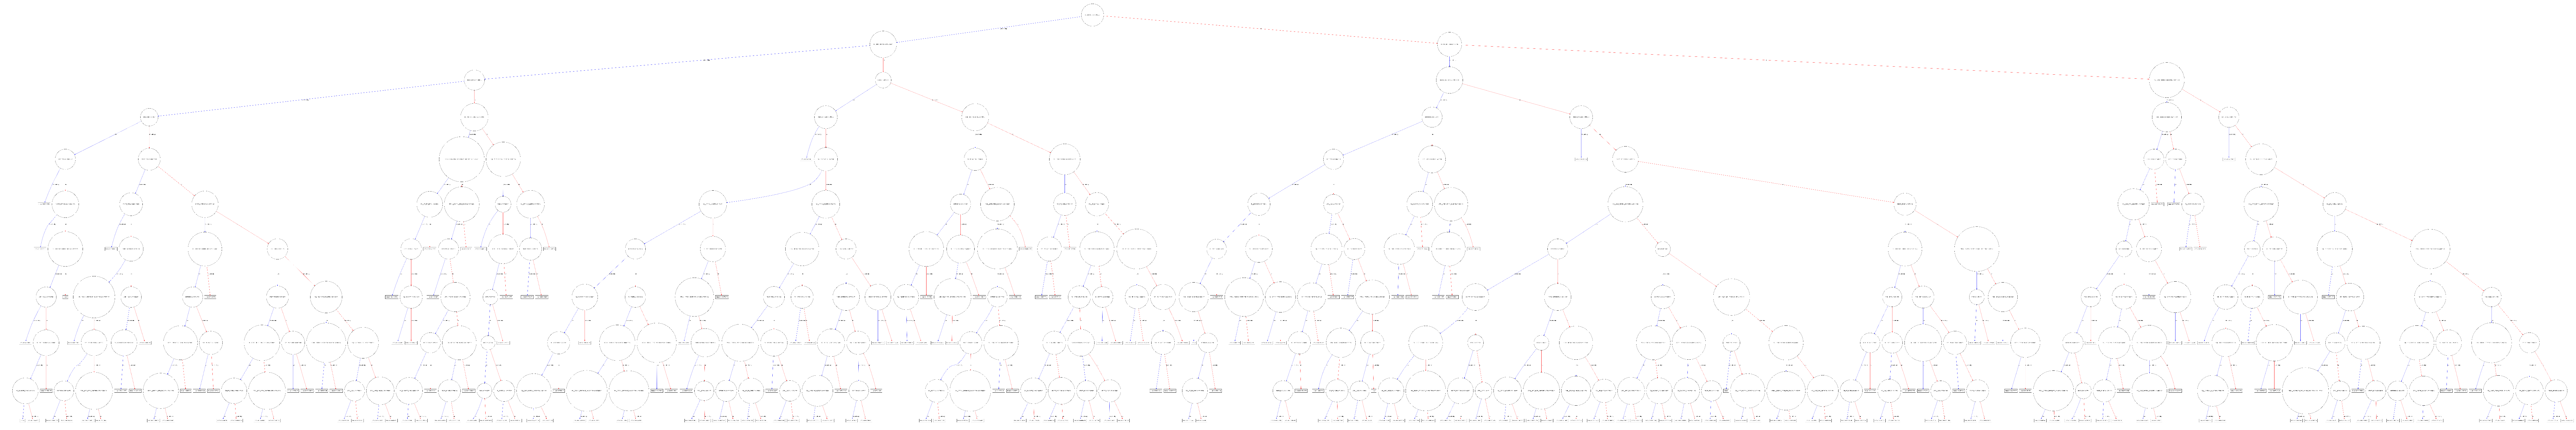

In [18]:
xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [250, 25]
plt.show()

In [19]:
dot = xgb.to_graphviz(model)
dot.render('Results/tree')

'Results/tree.pdf'

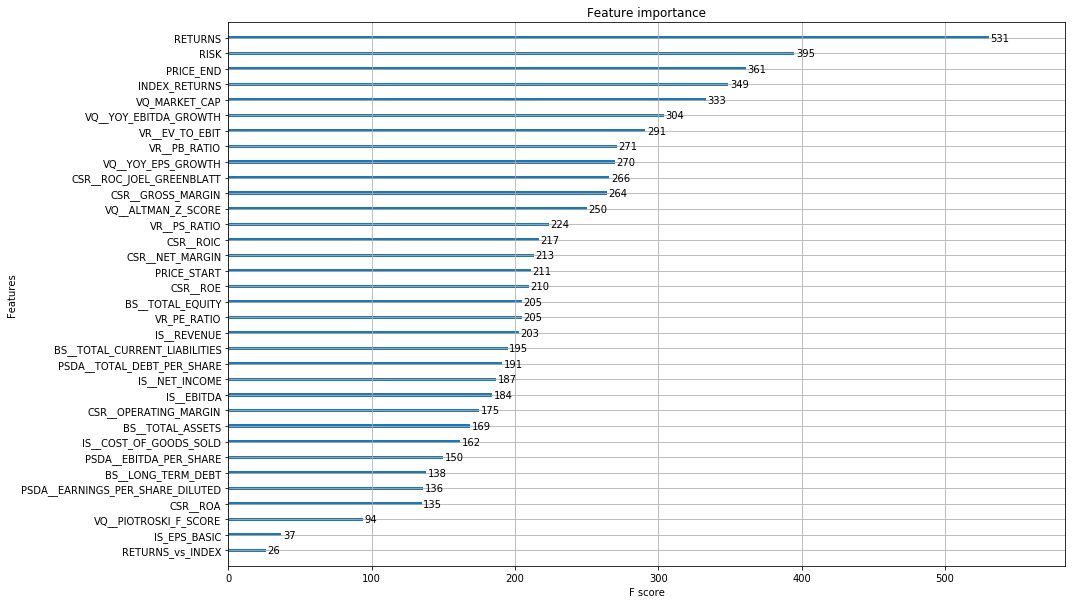

In [21]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()